In [7]:
from all_imports import *

import _modules

from _modules.plotColors import *


In [10]:
filepath: str  = r"C:\Users\gottk\OneDrive\Storage\Projects\2024-08-00_MTHCOM_Masterthesis-Outdoor-Comfort\Review\Review_dataset.csv"

#raw_data_df = pd.read_csv(filepath)
raw_data_df = pd.read_csv(filepath, encoding='ISO-8859-1')

raw_data_df = raw_data_df.dropna(subset=['Study_climateclassification'])
raw_data_df_overview_plot = raw_data_df[['Study_country', 'Study_latitude', 'Study_longitude', 'Study_climateclassification']].copy()
raw_data_df_overview_plot['number_of_points'] = 1

display(raw_data_df_overview_plot.head(5))

print(raw_data_df.columns)

,Study_country,Study_latitude,Study_longitude,Study_climateclassification,number_of_points
0,United Kingdom,52.20576,0.119167,Cfb,1
1,Canada,45.50169,-73.567253,Dfb,1
2,Bangladesh,23.81030,90.412500,Am,1
3,Isreal,29.88030,35.057500,Bwh,1
4,Australia,-33.86880,151.209300,Cfa,1


Index(['ID', 'general_doi', 'general_date', 'general_publisher',
       'general_title', 'general_authors', 'Study_country', 'Study_City',
       'Study_climateclassification', 'Study_latitude', 'Study_longitude',
       'StudyType', 'Keywords', 'Study_Environment',
       'Study_Environment_description', 'Study_Season', 'Study_Period',
       'Study_TimeofDay', 'Study_Duration (in h)',
       'Study_QuestionnaireDesign_available', 'Study_thermalsensation_scale',
       'Study_meterological_design', 'Study_NumberofSubjects',
       'Study_NumberofVotes', 'Study_Comfort_Indices',
       'Study_Physiological_factors', 'Study_Behavioral_factors',
       'Study_Other_factors', 'Study_goal'],
      dtype='object')


## Text Map

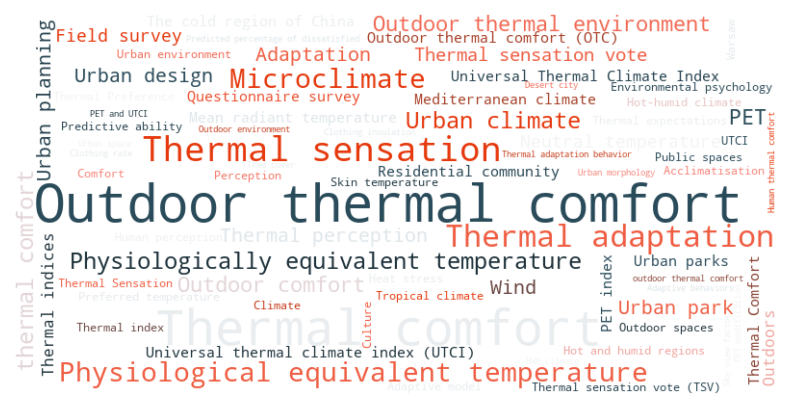

C:\Users\gottk\AppData\Local\Temp\ipykernel_27948\991488770.py:46: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frequency', y='Keyword', data=keyword_df, palette='viridis')


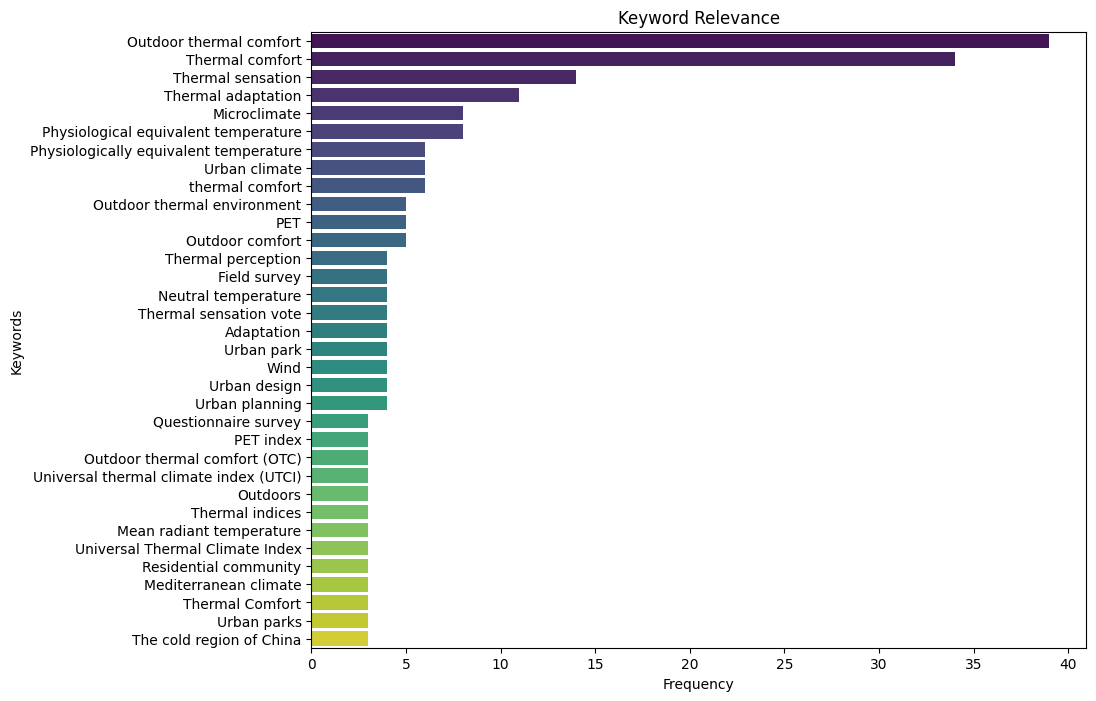

In [9]:
import pandas as pd
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming raw_data_df is your DataFrame

# Step 1: Remove duplicates based on the 'general_title' column
raw_data_df_cleaned = raw_data_df.drop_duplicates(subset='general_title')

# Step 2: Filter out rows where 'Keywords' is NaN or '-'
filtered_df = raw_data_df_cleaned[(raw_data_df_cleaned['Keywords'].notna()) & (raw_data_df_cleaned['Keywords'] != '-')]

# Step 3: Extract and split the keywords
keywords_series = filtered_df['Keywords'].str.split(':')
all_keywords = keywords_series.explode().str.strip()

# Step 4: Calculate the frequency of each keyword
keyword_frequencies = Counter(all_keywords)

# Step 5: Generate the word cloud with frequencies
wordcloud = WordCloud(
    width=800, 
    height=400, 
    background_color='white', 
    colormap=gradient_lightvulcanelderberry,  # Use a colormap to differentiate
    max_words=75
).generate_from_frequencies(keyword_frequencies)

# Step 6: Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()



# Maybe?
# Step 7: Convert to DataFrame and filter out items with frequency < 3
keyword_df = pd.DataFrame(keyword_frequencies.items(), columns=['Keyword', 'Frequency'])
keyword_df = keyword_df[keyword_df['Frequency'] >= 3].sort_values(by='Frequency', ascending=False)

# Step 8: Plot the bar chart
plt.figure(figsize=(10, 8))
sns.barplot(x='Frequency', y='Keyword', data=keyword_df, palette='viridis')
plt.title('Keyword Relevance')
plt.xlabel('Frequency')
plt.ylabel('Keywords')
plt.show()


## Location Data

C:\Users\gottk\AppData\Local\Temp\ipykernel_27948\388094332.py:21: FutureWarning:

The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.



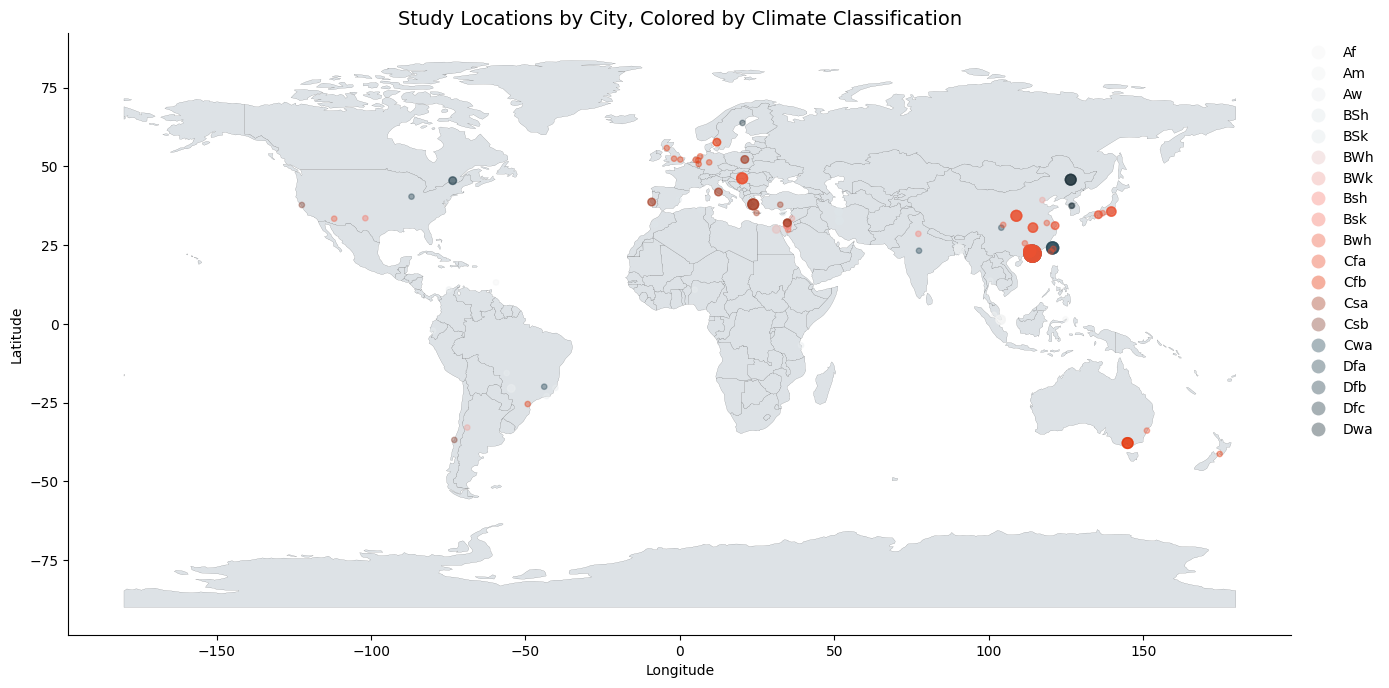

In [49]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point

# Assuming your DataFrame is called raw_data_df
df = raw_data_df

# Step 1: Aggregate the data by city and country to count the number of studies
size_df = df.groupby(['Study_country', 'Study_City']).size().reset_index(name='Study_Count')

# Step 2: Merge the aggregated study count back into the original DataFrame
df = pd.merge(df, size_df, on=['Study_country', 'Study_City'])

# Step 3: Create a GeoDataFrame using the Study_longitude and Study_latitude columns
gdf = gpd.GeoDataFrame(df, 
                       geometry=gpd.points_from_xy(df['Study_longitude'], df['Study_latitude']),
                       crs="EPSG:4326")  # WGS84 Latitude/Longitude

# Step 4: Load a base world map using GeoPandas
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Step 5: Plot the map and the study locations, colored by Study_climateclassification
fig, ax = plt.subplots(figsize=(14, 10))

# Plot the base world map
world.plot(ax=ax, color=tum_grey_7, edgecolor="black", linewidth=0.075)

# Plot the study locations with size based on Study_Count and colored by Study_climateclassification
gdf_plot = gdf.plot(ax=ax, 
                    markersize=gdf['Study_Count'] * 15,  # Adjust the multiplier for size
                    column='Study_climateclassification',  # Color by climate classification
                    cmap=gradient_lightvulcanelderberry,  # Colormap for the points; you can change this to your preference
                    alpha=0.4, 
                    legend=True,  # Enable the legend
                    legend_kwds={'bbox_to_anchor': (1.0, 1), 'loc': 'upper left'})  # Move legend to the right

legend = ax.get_legend()
legend.set_frame_on(False)

# Customize spines: remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Add titles and labels
ax.set_title('Study Locations by City, Colored by Climate Classification', fontsize=14)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Adjust layout to make room for the legend
plt.tight_layout()

# Show the plot
plt.show()

## Amount of Studies

C:\Users\gottk\AppData\Local\Temp\ipykernel_27948\3475837225.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



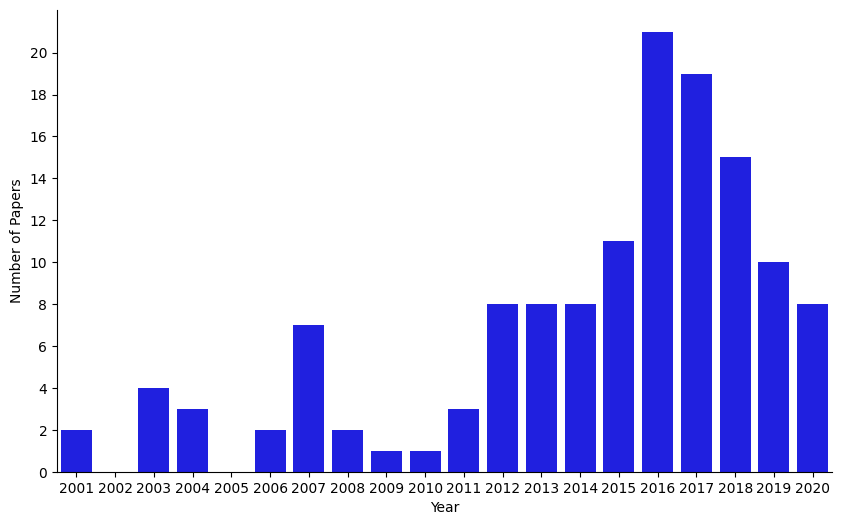

In [21]:
#TODO Stacked Barchart by studytype and main climate region (2 charts) GROUP THEM CORRECTLY

# Remove duplicate titles
raw_data_df = raw_data_df.drop_duplicates(subset='general_title')

# Ensure the general_date column is treated as integer (year)
raw_data_df['year'] = raw_data_df['general_date'].astype(int)

# Group by year and count the number of papers published each year
papers_per_year = raw_data_df.groupby('year').size().reset_index(name='count')

# Reindex to include all years and fill missing values with zeros
all_years = pd.DataFrame({'year': range(papers_per_year['year'].min(), papers_per_year['year'].max() + 1)})
papers_per_year = all_years.merge(papers_per_year, on='year', how='left').fillna(0)

# Create a bar chart
plt.figure(figsize=(10, 6))
sns.barplot(data=papers_per_year, x='year', y='count', color='blue')

# Remove right and top spines
sns.despine(right=True, top=True)

# Sort y-axis by 2 increments
plt.yticks(range(0, int(papers_per_year['count'].max()) + 1, 2))

# Remove title
plt.title('')

# Add labels
plt.xlabel('Year')
plt.ylabel('Number of Papers')

# Show the plot
plt.show()
